In [1]:
%load_ext autoreload
%autoreload 2 

* 이미지를 VAE로 Embedding하여 얻은 vector의 similarity와 풍속데이터의 Similarity 비교
* 체크해야 할 것
    - 풍속기록이 있는 데이터만 필요하며, 일부는 Train 일부는 test 이를 구분해야 할 필요가 있음

In [2]:
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image

import yaml
import torch
from torchvision import transforms, datasets
from torch.utils.data import SubsetRandomSampler, DataLoader, TensorDataset

from src.hillshpaeDataModule import MySimCLRTrainDataTransform
from simCLR import *
from src import *

In [3]:
# Wind data load

with open('../../Share_Data/windspeed/_Main_dataset.pickle', 'rb') as f:
    windspeed_dataset = pickle.load(f)

# --- filter station for WAS journal!!
with open('../../Share_Data/windspeed/WAS_except_station_list_under_30_m.pickle', 'rb') as f:
    except_list = pickle.load(f)

new_windspeed_dataset = {}
for key in windspeed_dataset:
    if key not in except_list:
        new_windspeed_dataset[key] = windspeed_dataset[key]
        
windspeed_dataset = new_windspeed_dataset
# -------------------------------------- #
    
station_list = list(windspeed_dataset.keys())
windspeed_list = []
for item in windspeed_dataset.values():
    windspeed_list.append(item[3])
windspeed_list = np.array(windspeed_list)

In [4]:
# load config
config_path = 'configs/simclr_rgb.yaml'
checkpoint_path = '../../Share_Data/logs/SimCLR_CART/last.ckpt'

with open(config_path, 'rb') as f:
    config = yaml.safe_load(f)

#load vae model
untrained_model = simclr_model[config['model_params']['name']](**config['model_params'], num_samples=10)
model = simclr_model[config['model_params']['name']](**config['model_params'], num_samples=10)

#checkpoint load
checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu')) # when using CPU
model.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

In [5]:
# load img data
IMG_PATH = '../../Share_Data/satellite/jpg_cart_d10/_jpg_cart_d10/{}.jpg'

img_list =[ ]
label_list = []
for station_code in station_list:
    img = Image.open(IMG_PATH.format(station_code)).resize([config['exp_parmas']['img_size']]*2)
    img_list.append(np.array(img))
    label_list.append(station_code)

img_list = (np.array(img_list)/255.)*2-1
tensor_img = torch.Tensor(img_list).permute(0,3,1,2)
tensor_dataset = TensorDataset(tensor_img)
dataloader = DataLoader(tensor_dataset)

In [6]:
model_latent = model.forward(tensor_img)
untrained_latent = untrained_model.forward(tensor_img)

model_projection = model.Projection(model_latent)
untrained_model_projection = untrained_model.Projection(untrained_latent)

print('size of latent : {}'.format(model_latent.size()))
print('size of projection : {}'.format(model_projection.size()))

size of latent : torch.Size([318, 512, 4, 4])
size of projection : torch.Size([318, 32])


# Analysis

In [7]:
#windspeed difference matrix

windspeed_diff_list = []
for i in windspeed_list:
    temp_list = []
    for j in windspeed_list:
        temp_list.append(abs(i-j))
    windspeed_diff_list.append(temp_list)
windspeed_diff_list = np.array(windspeed_diff_list)

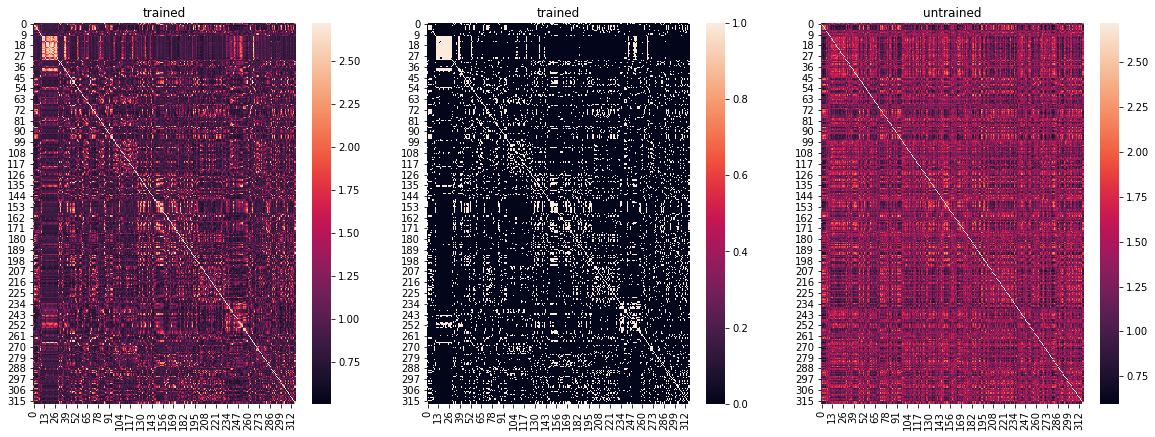

In [8]:
model_n = model_projection.norm(dim=1)[:,None]
model_n = torch.max(model_n, 1e-8*torch.ones_like(model_n))

un_model_n = untrained_model_projection.norm(dim=1)[:, None]
un_model_n = torch.max(un_model_n, 1e-8*torch.ones_like(un_model_n))

cov = torch.mm(model_projection/model_n, (model_projection/model_n).t().contiguous())
sim = torch.exp(cov)
untrained_cov = torch.mm(untrained_model_projection/un_model_n, (untrained_model_projection/un_model_n).t().contiguous())
untrained_sim = torch.exp(untrained_cov)

windspeed_diff = np.exp(-windspeed_diff_list/windspeed_diff_list.max()+1)

plt.figure(figsize=(20,7))
plt.subplot(1,3,1)
plt.title('trained')
sns.heatmap(sim.detach().numpy())

plt.subplot(1,3,2)
plt.title('trained')
sns.heatmap(sim.detach().numpy()>1.5)

plt.subplot(1,3,3)
plt.title('untrained')
sns.heatmap(untrained_sim.detach().numpy())

#plt.subplot(1,3,3)
#plt.title('windspeed')
#sns.heatmap(windspeed_diff)
plt.show()

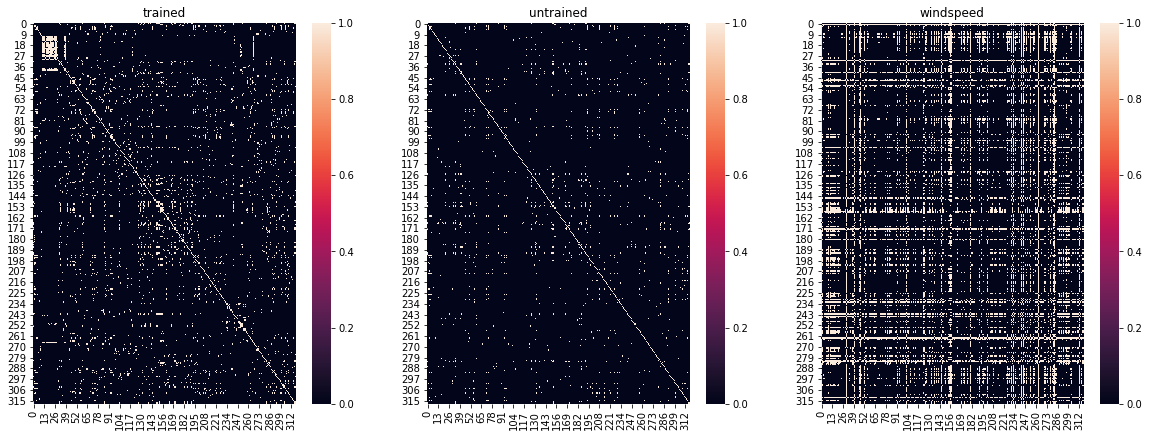

In [9]:

plt.figure(figsize=(20,7))
plt.subplot(1,3,1)
plt.title('trained')
sns.heatmap(sim.detach().numpy()>2)

plt.subplot(1,3,2)
plt.title('untrained')
sns.heatmap(untrained_sim.detach().numpy()>2)

plt.subplot(1,3,3)
plt.title('windspeed')
sns.heatmap(windspeed_diff<2)
plt.show()

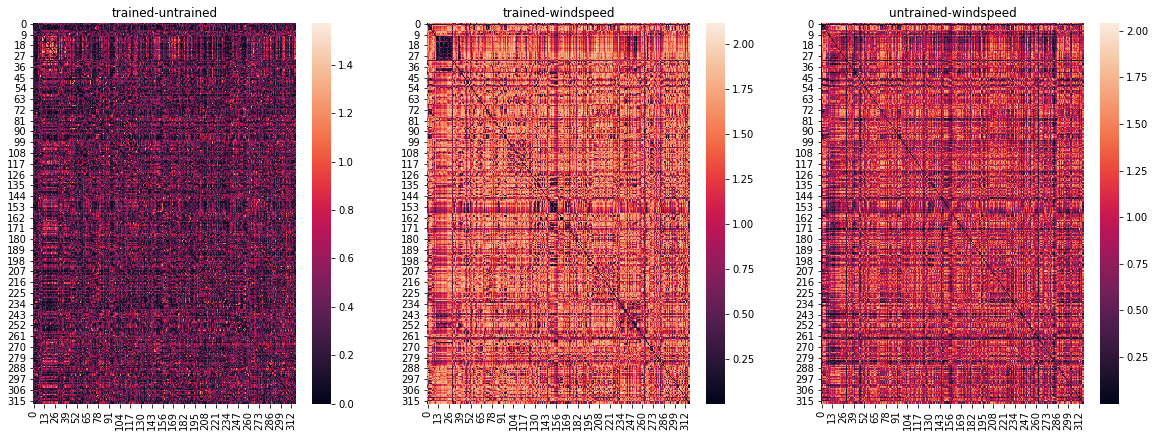

In [10]:
plt.figure(figsize=(20,7))
plt.subplot(1,3,1)
plt.title('trained-untrained')
sns.heatmap(abs(sim.detach().numpy()-untrained_sim.detach().numpy()))

plt.subplot(1,3,2)
plt.title('trained-windspeed')
sns.heatmap(abs(sim.detach().numpy()-windspeed_diff))

plt.subplot(1,3,3)
plt.title('untrained-windspeed')
sns.heatmap(abs(untrained_sim.detach().numpy()-windspeed_diff))
plt.show()

---

# Content

* [latent_vector의 Similarity로 KNN하여 풍속 예측](#Experiment_1)
* [latent_vector의 Similarity로 KNN하여 풍속 예측+CART로 다시한것](#Experiment_2)
* [KNN, Similarity Distance](#Experiment_3)


* [Report 1](#Report_1) *66번 인덱스*
* [Report 2](#Report_2) *104번 인덱스*
* [Report 3](#Report_3) *345번 인덱스*
* [Report 4](#Report_4) *4번 인덱스*
* [Report 5](#Report_5) *309번 인덱스*
* [Report 6](#Report_6) *39번 인덱스*

---

# Experiment_3
* KNN, apply Similarity Weight

[go to content](#Content)

In [11]:
with open('../../Share_Data/windspeed/Baseline_KNN_group.pickle', 'rb') as f:
    KNN_group = pickle.load(f)

with open('../../Share_Data/windspeed/Baseline_KNN_error.pickle', 'rb') as f:
    KNN_error = pickle.load(f)
    
with open('../../Share_Data/windspeed/Baseline_KNN_abs_error.pickle', 'rb') as f:
    KNN_abs_error = pickle.load(f)

# ---- WAS Journal
with open('../../Share_Data/windspeed/WAS_KNN_group.pickle', 'rb') as f:
    KNN_group = pickle.load(f)

with open('../../Share_Data/windspeed/WAS_KNN_error.pickle', 'rb') as f:
    KNN_abs_error = pickle.load(f)

KNN_error = abs(KNN_abs_error)
# ------------------- #

cov_np = sim.detach().numpy()

# For WAS

In [17]:
# --- map library
import folium
from folium import plugins

temp_Y = 37.5722440
temp_X = 126.9759352
main_location = (temp_Y, temp_X) # 지도를 보여줄 떄 중심이 되는 위치

mean : 3.206061993488963
std : 2.6085987068068732


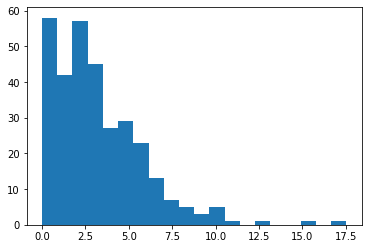

In [72]:
# K = 15, Similarity 반영

similarity_list =[]
exp3_result = []

for index, station_code in enumerate(list(windspeed_dataset)):
    NN_group = list(KNN_group[station_code])
    NN_index = list(map(lambda x:list(windspeed_dataset).index(x), NN_group))
    similarity_list.append(cov_np[index][NN_index])
    NN_windspeed = windspeed_list[NN_index]
    exp3_result.append(sum(NN_windspeed*1/(cov_np[index][NN_index]))/sum(1/(cov_np[index][NN_index])))
    
_result = exp3_result-windspeed_list
#plt.hist(_result, bins=20)
#print('mean : {}'.format(np.mean(_result)))
#print('std : {}'.format(np.std(_result)))
#plt.show()

plt.hist(abs(_result), bins=20)
print('mean : {}'.format(np.mean(abs(_result))))
print('std : {}'.format(np.std(abs(_result))))
plt.show()

In [75]:
# Except 10
N = 10
_test = abs(_result)
idx_test = dict(zip(np.arange(len(_test)), _test))
except_idx = np.array(sorted(idx_test.items(), key=lambda x:x[1], reverse=True)[:N])[:,0].astype(np.int32)
_test = np.delete(_test, except_idx)
print(np.mean(_test))

# Except 20
N = 20
_test = abs(_result)
idx_test = dict(zip(np.arange(len(_test)), _test))
except_idx = np.array(sorted(idx_test.items(), key=lambda x:x[1], reverse=True)[:N])[:,0].astype(np.int32)
_test = np.delete(_test, except_idx)
print(np.mean(_test))

# correct 20
N = 20
_test = abs(_result)
idx_test = dict(zip(np.arange(len(_test)), _test))
good_idx = np.array(sorted(idx_test.items(), key=lambda x:x[1], reverse=False)[:N])[:,0].astype(np.int32)
_test = np.delete(_test, good_idx)
print(np.mean(_test))
_test = _test

2.9310011121683153
2.7545651480130533
3.4141381307594454


In [76]:
map_eachone = folium.Map(location=main_location, zoom_start=8)
folium.TileLayer('stamentoner').add_to(map_eachone)

_test = _result

# visualization
for idx, code in enumerate(windspeed_dataset):
    location = windspeed_dataset[code][:2]
    if abs(_test[idx]) > 10 :
        folium.CircleMarker(location, radius=3, color='orange').add_to(map_eachone)        
    if idx in except_idx:
        folium.CircleMarker(location, radius=1, color='red').add_to(map_eachone)
    elif idx in good_idx:
        folium.CircleMarker(location, radius=1, color='blue').add_to(map_eachone)
    else :
        folium.CircleMarker(location, radius=0.5, color='green').add_to(map_eachone)
        
        
map_eachone

In [85]:
map_eachone = folium.Map(location=main_location, zoom_start=8)
folium.TileLayer('stamentoner').add_to(map_eachone)

_test = _result
cnt = [0]*6

# visualization
for idx, code in enumerate(windspeed_dataset):
    location = windspeed_dataset[code][:2]
    if _test[idx] >= 10:
        cnt[0]+=1
        folium.CircleMarker(location, radius=3, color='green').add_to(map_eachone)
    elif _test[idx] >= 5:
        cnt[1]+=1
        folium.CircleMarker(location, radius=1, color='green').add_to(map_eachone)
    elif _test[idx] >= 0:
        cnt[2]+=1
        folium.CircleMarker(location, radius=0.5, color='blue').add_to(map_eachone)
    elif _test[idx] >= -5:
        cnt[3]+=1
        folium.CircleMarker(location, radius=0.5, color='blue').add_to(map_eachone)
    elif _test[idx] >= -10:
        cnt[4]+=1
        folium.CircleMarker(location, radius=1, color='red').add_to(map_eachone)
    else :
        cnt[5]+=1
        folium.CircleMarker(location, radius=3, color='red').add_to(map_eachone)
print(cnt)
map_eachone

[0, 26, 144, 107, 35, 6]


In [36]:
ML_more_good = abs(KNN_abs_error)-abs(_test)

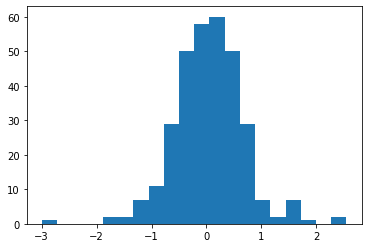

In [45]:
plt.hist(ML_more_good, bins=20)
plt.show()

In [91]:
ML_more_good

array([-5.12996034e-01, -3.56390316e-01,  1.22039632e-01, -1.92690182e-01,
        2.24409132e+00,  8.50524385e-01, -1.04326980e+00, -6.20457169e-01,
        6.07562772e-01,  2.14156639e+00, -3.77430461e-01, -2.80808828e-01,
       -1.04056557e-02, -6.67610150e-02, -5.38752991e-01,  2.87434775e-01,
        2.69314232e-01, -2.38710556e-01,  3.47023700e-01,  9.33217802e-02,
        5.16593374e-01, -6.45126619e-02,  1.16750981e-01,  2.39633254e-01,
       -2.57124148e-01,  1.66773903e-01, -1.46094985e-01,  2.19632678e-01,
        2.37436424e-02, -1.65056135e-01,  3.59724479e-01, -4.79479680e-01,
        2.83920981e-01, -4.67197102e-01,  5.87385371e-01,  1.08719504e-01,
       -1.10727187e+00, -8.60778181e-02,  2.96051442e-01,  4.94224858e-02,
        1.43467002e-02,  2.41549326e-01, -4.82686148e-01, -4.10681463e-01,
        4.76288084e-01,  1.29598074e+00,  7.81930549e-01, -4.38590245e-02,
       -3.98084075e-01, -2.79694645e-01,  3.96009785e-01, -2.16270789e-01,
        3.98072397e-01,  

In [99]:
map_eachone = folium.Map(location=main_location, zoom_start=8)
folium.TileLayer('stamentoner').add_to(map_eachone)

# visualization
for idx, code in enumerate(windspeed_dataset):
    location = windspeed_dataset[code][:2]
    if ML_more_good[idx]>=0.5:
        folium.CircleMarker(location, radius=2, color='blue').add_to(map_eachone)
    elif ML_more_good[idx]>= -1:
        folium.CircleMarker(location, radius=1, color='green').add_to(map_eachone)
    else :
        folium.CircleMarker(location, radius=2, color='red').add_to(map_eachone)

        
map_eachone

In [52]:
# K = 15, Similarity 반영

similarity_list =[]
exp3_result = []

for index, station_code in enumerate(list(windspeed_dataset)):
    NN_group = list(KNN_group[station_code])
    NN_index = list(map(lambda x:list(windspeed_dataset).index(x), NN_group))
    similarity_list.append(cov_np[index][NN_index])
    NN_windspeed = windspeed_list[NN_index]
    exp3_result.append(sum(NN_windspeed*1/(cov_np[index][NN_index]))/sum(1/(cov_np[index][NN_index])))

mean : 3.4098354064074994
std : 2.7943741570337073


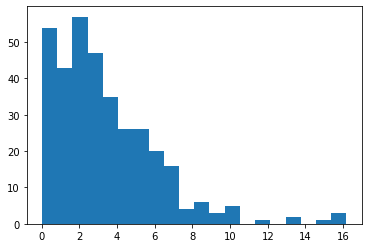

In [53]:
_result = exp3_result-windspeed_list
#plt.hist(_result, bins=20)
#print('mean : {}'.format(np.mean(_result)))
#print('std : {}'.format(np.std(_result)))
#plt.show()

_result = np.abs(_result)
plt.hist(_result, bins=20)
print('mean : {}'.format(np.mean(_result)))
print('std : {}'.format(np.std(_result)))
plt.show()


In [54]:
# Except 10
N = 10
_test = _result
for _ in range(N):
    _test = np.delete(_test, np.where(_test==max(_test))[0])
print(np.mean(_test))

# Except 20
N = 20
_test = _result
for _ in range(N):
    _test = np.delete(_test, np.where(_test==max(_test))[0])
print(np.mean(_test))

3.1258650019321848
2.9468748112092484


### Sub Analysis 
* place distance vs similarity distance

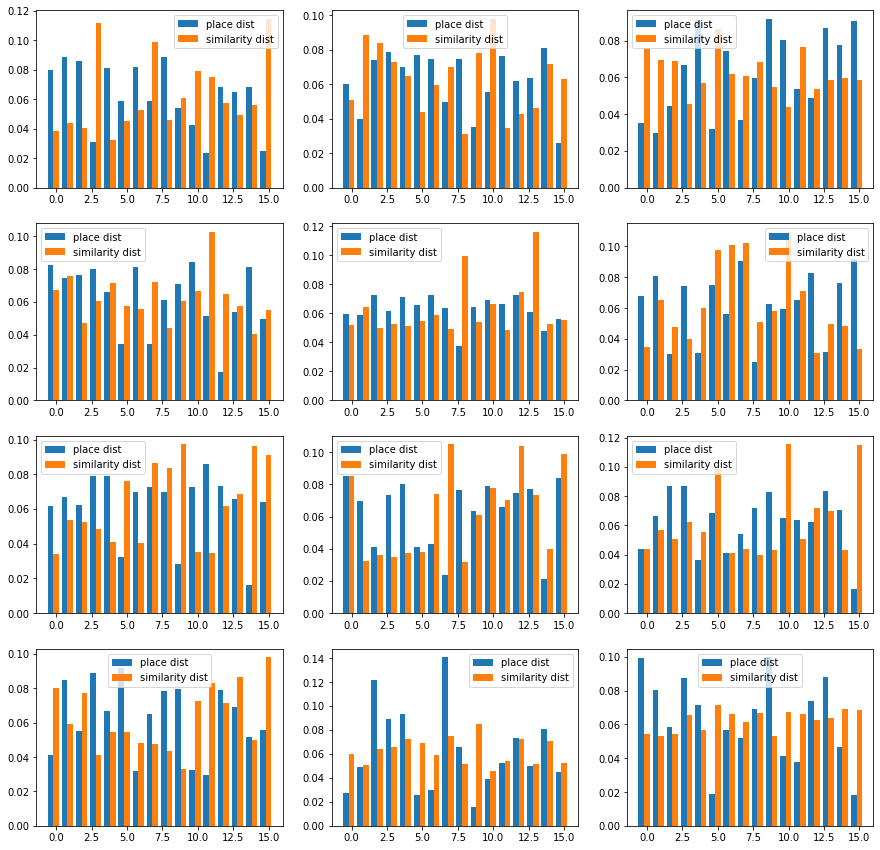

In [88]:
select_Num = 12
print_col = 3
print_row = 4

random_select = np.random.permutation(np.arange(len(windspeed_list)))[:select_Num]

plt.figure(figsize=(15,15))
for i, index in enumerate(random_select):
    staion_code = np.array(list(KNN_group))[index]
    plt.subplot(print_row, print_col, i+1)
    plt.bar(np.arange(len(KNN_group[staion_code]))-0.4, np.array(list(KNN_group[staion_code].values()))/sum(list(KNN_group[staion_code].values())), width=0.4, label='place dist')
    plt.bar(np.arange(len(KNN_group[staion_code])), similarity_list[index]/sum(similarity_list[index]), width=0.4,label='similarity dist')
    plt.legend()
plt.show()

In [69]:
print('KNN에 비해 개선 된 결과 수 : {}, 나빠진 곳 : {}, 총 : {}'.format(sum(KNN_error > _result), sum(KNN_error < _result), len(KNN_error)))

KNN에 비해 개선 된 결과 수 : 176, 나빠진 곳 : 173, 총 : 349


* 오... 생각보다 많이 개선 되네?

### 단순히 2개의 평균을 해보자

In [49]:
# origin - KNN
mean_result = (0.5*(KNN_abs_error)+0.5*(exp3_result-windspeed_list))/1

mean : 3.2179278662535813
std : 2.605269640966396


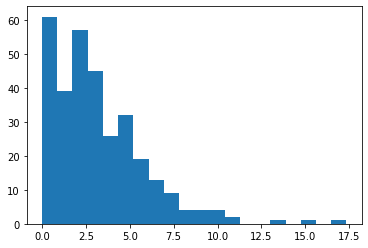

In [50]:
#plt.hist(mean_result, bins=20)
#print('mean : {}'.format(np.mean(mean_result)))
#print('std : {}'.format(np.std(mean_result)))
#plt.show()

_result = np.abs(mean_result)
plt.hist(_result, bins=20)
print('mean : {}'.format(np.mean(_result)))
print('std : {}'.format(np.std(_result)))
plt.show()

In [34]:
# Except 10
N = 10
_test = abs(mean_result)
for _ in range(N):
    _test = np.delete(_test, np.where(_test==max(_test))[0])
print(np.mean(_test))

# Except 20
N = 20
_test = abs(mean_result)
for _ in range(N):
    _test = np.delete(_test, np.where(_test==max(_test))[0])
print(np.mean(_test))

2.942964478801125
2.7663412041887443


In [51]:
Y = list(map(lambda x : np.mean(np.abs(x*(KNN_abs_error)+(1-x)*(exp3_result-windspeed_list)/1)), np.arange(0,1,0.01)))

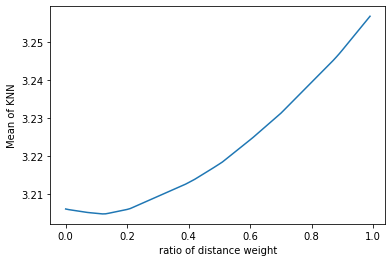

In [52]:
plt.plot(np.arange(0,1,0.01), Y)
plt.ylabel('Mean of KNN')
plt.xlabel('ratio of distance weight')
plt.show()

In [53]:
min(Y)

3.204759093480512

In [54]:
np.where(Y==min(Y))

(array([12]),)

In [55]:
# origin - KNN
mean_result = (0.12*(KNN_abs_error)+0.88*(exp3_result-windspeed_list))/1

mean : 3.204759093480512
std : 2.608941770853679


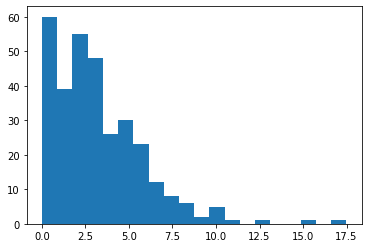

In [56]:
#plt.hist(mean_result, bins=20)
#print('mean : {}'.format(np.mean(mean_result)))
#print('std : {}'.format(np.std(mean_result)))
#plt.show()

_result = np.abs(mean_result)
plt.hist(_result, bins=20)
print('mean : {}'.format(np.mean(_result)))
print('std : {}'.format(np.std(_result)))
plt.show()

In [58]:
# Except 10
N = 10
_test = np.abs(mean_result)
for _ in range(N):
    _test = np.delete(_test, np.where(_test==max(_test))[0])
print(np.mean(_test))

# Except 20
N = 20
_test = np.abs(mean_result)
error_list = []
for _ in range(N):
    error_list.append(np.where(_test==max(_test))[0][-1])
    _test = np.delete(_test, np.where(_test==max(_test))[0])
print(np.mean(_test))

# correct 20
N = 20
_test = abs(mean_result)
good_list = []
for _ in range(N):
    good_list.append(np.where(_test==min(_test))[0][-1])
    _test = np.delete(_test, np.where(_test==min(_test))[0][-1])
print(np.mean(_test))

2.929586848276145
2.753244488911077
3.413314424052814


In [59]:
ML_more_good = abs(KNN_abs_error)-abs(mean_result)

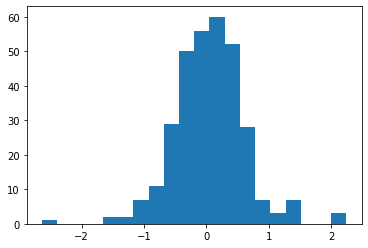

In [60]:
plt.hist(ML_more_good, bins=20)
plt.show()

In [61]:
map_eachone = folium.Map(location=main_location, zoom_start=8)
folium.TileLayer('stamentoner').add_to(map_eachone)


# visualization
for idx, code in enumerate(windspeed_dataset):
    location = windspeed_dataset[code][:2]
    if ML_more_good[idx]>=1:
        folium.CircleMarker(location, radius=2, color='blue').add_to(map_eachone)
    elif ML_more_good[idx]>=0:
        folium.CircleMarker(location, radius=1, color='blue').add_to(map_eachone)
    elif ML_more_good[idx]>=-1:
        folium.CircleMarker(location, radius=1, color='red').add_to(map_eachone)
    else :
        folium.CircleMarker(location, radius=2, color='red').add_to(map_eachone)

        
map_eachone

In [68]:
sum(ML_more_good>=0)

172

In [69]:
sum(ML_more_good<0)

146

# Experiment_2
* 한번 latent_vector의 similarty를 기준으로 구해볼까...?
* windspeed의 기록을 CART가 분류한 값을 이용해서

[go to content](#Content)

In [45]:
import geopy.distance as gedistc

In [80]:
with open('../../Share_Data/windspeed/New_Windspeed.pickle', 'rb') as f:
    new_windspeed = pickle.load(f)

In [46]:
with open('../../Share_Data/windspeed/cart_change_windspeed.pickle', 'rb') as f:
    cart_windspeed = pickle.load(f)

In [82]:
num_K = 15
cov_np = sim.detach().numpy()
similar_list = []
result = []

wind_select_f = lambda x : list(new_windspeed.values())[x]
code_select_f = lambda x : list(windspeed_dataset)[x]

# 가중치 없이 그냥 평균
for i_index in range(len(station_list)):
    select_list = cov_np[i_index].argsort()[-1-num_K : -1]
    select_wind = list(map(wind_select_f, select_list))
    select_code = list(map(code_select_f, select_list))
    select_dic = dict(zip(select_code, select_wind))
    similar_list.append(select_dic)
    
    result.append(np.mean(select_wind))

In [83]:
# distance weight sum

weight_result = []

for i_index, (to_code, to_dic) in enumerate(windspeed_dataset.items()):
    to_place = to_dic[:2]
    distance_list = []
    for j_index in similar_list[i_index]:
        from_place = windspeed_dataset[j_index][:2]
        distance_list.append(1/gedistc.distance(to_place, from_place).km) 
    weight_windspeed = sum(np.array(list(similar_list[i_index].values())) * np.array(distance_list))
    weight_result.append(weight_windspeed/sum(distance_list))

3.913177631571559
3.1589076148570734


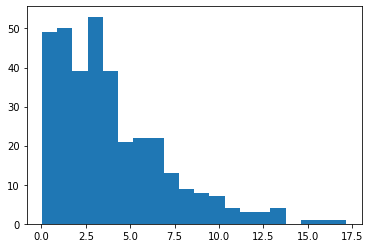

In [86]:
# --- k = 15
# --- Not distance Weight

#plt.hist(windspeed_list-result, bins=20)
#print(np.mean(windspeed_list-result))
#print(np.std(windspeed_list-result))
#plt.show()
data = np.abs(windspeed_list-result)

plt.hist(data, bins=20)
print(np.mean(data))
print(np.std(data))
plt.show()

In [87]:
# Except 10
N = 10
_test = data
for _ in range(N):
    _test = np.delete(_test, np.where(_test==max(_test))[0])
print(np.mean(_test))

# Except 20
N = 20
_test = data
for _ in range(N):
    _test = np.delete(_test, np.where(_test==max(_test))[0])
print(np.mean(_test))

3.6207894211071614
3.4015470423424383


4.004224803777523
3.290753080463873


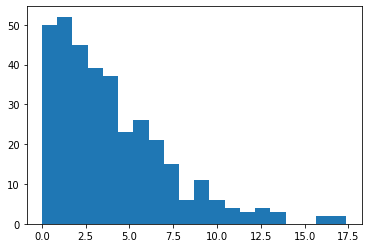

In [85]:
# --- k = 15
# --- apply distance Weight

#plt.hist(windspeed_list-weight_result, bins=20)
#print(np.mean(windspeed_list-weight_result))
#print(np.std(windspeed_list-weight_result))
#plt.show()

plt.hist(np.abs(windspeed_list-weight_result), bins=20)
print(np.mean(np.abs(windspeed_list-weight_result)))
print(np.std(np.abs(windspeed_list-weight_result)))
plt.show()

## Conclusion

* 이게더 좋긴함

---
# Experiment_1
* 한번 latent_vector의 similarty를 기준으로 구해볼까...?

[go to content](#Content)

In [43]:
import geopy.distance as gedistc

In [44]:
num_K = 15
cov_np = sim.detach().numpy()
similar_list = []
result = []

wind_select_f = lambda x : windspeed_list[x]
code_select_f = lambda x : list(windspeed_dataset)[x]

# 가중치 없이 그냥 평균
for i_index in range(len(station_list)):
    select_list = cov_np[i_index].argsort()[-1-num_K : -1]
    select_wind = list(map(wind_select_f, select_list))
    select_code = list(map(code_select_f, select_list))
    select_dic = dict(zip(select_code, select_wind))
    similar_list.append(select_dic)
    
    result.append(np.mean(select_wind))

In [45]:
# distance weight sum

weight_result = []

for i_index, (to_code, to_dic) in enumerate(windspeed_dataset.items()):
    to_place = to_dic[:2]
    distance_list = []
    for j_index in similar_list[i_index]:
        from_place = windspeed_dataset[j_index][:2]
        distance_list.append(1/gedistc.distance(to_place, from_place).km) 
    weight_windspeed = sum(np.array(list(similar_list[i_index].values())) * np.array(distance_list))
    weight_result.append(weight_windspeed/sum(distance_list))

3.2881552540151584
2.614111810095754


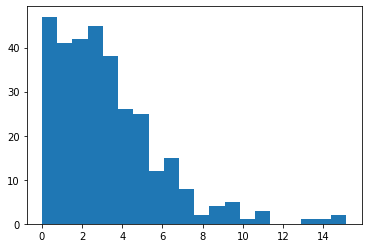

In [46]:
# --- k = 15
# --- Not distance Weight

#plt.hist(windspeed_list-result, bins=20)
#print(np.mean(windspeed_list-result))
#print(np.std(windspeed_list-result))
#plt.show()

data = np.abs(windspeed_list-result)

plt.hist(data, bins=20)
print(np.mean(data))
print(np.std(data))
plt.show()

In [47]:
# Except 10
N = 10
_test = data
for _ in range(N):
    _test = np.delete(_test, np.where(_test==max(_test))[0])
print(np.mean(_test))

# Except 20
N = 20
_test = data
for _ in range(N):
    _test = np.delete(_test, np.where(_test==max(_test))[0])
print(np.mean(_test))

3.00760343054338
2.8214108304486234


3.4140993766006873
2.685167700768747


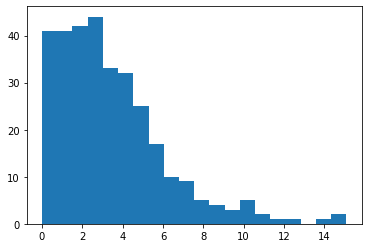

In [48]:
# --- k = 15
# --- apply distance Weight

#plt.hist(windspeed_list-weight_result, bins=20)
#print(np.mean(windspeed_list-weight_result))
#print(np.std(windspeed_list-weight_result))
#plt.show()

data = np.abs(windspeed_list-weight_result)

plt.hist(data, bins=20)
print(np.mean(data))
print(np.std(data))
plt.show()

In [49]:
# Except 10
N = 10
_test = data
for _ in range(N):
    _test = np.delete(_test, np.where(_test==max(_test))[0])
print(np.mean(_test))

# Except 20
N = 20
_test = data
for _ in range(N):
    _test = np.delete(_test, np.where(_test==max(_test))[0])
print(np.mean(_test))

3.1336539573825686
2.931583498782878


## 이전에 baseline에서 잘 안나온 것들 확인해보자

##  Report 1

In [108]:
list(new_windspeed_dataset.keys()).index('538')

58

In [109]:
_result[58]

-3.1741832927111773

##  Report 2

In [100]:
list(new_windspeed_dataset.keys()).index('162')

282

In [101]:
_result[282]

-9.324441597399261

## Report 3

In [102]:
list(new_windspeed_dataset.keys()).index('294')

316

In [103]:
_result[316]

6.178541142104917

In [115]:
list(new_windspeed_dataset.keys()).index('918')

240

In [116]:
a_index = 316
b_index = 234
c_index = 235
d_index = 239
e_index = 240

In [117]:
# z list
select_value = []
select_value.append(model_projection[a_index].detach().numpy())
select_value.append(model_projection[b_index].detach().numpy())
select_value.append(model_projection[c_index].detach().numpy())
select_value.append(model_projection[d_index].detach().numpy())
select_value.append(model_projection[e_index].detach().numpy())

# origin
img_a = (img_list[a_index]+1)/2
img_b = (img_list[b_index]+1)/2
img_c = (img_list[c_index]+1)/2
img_d = (img_list[d_index]+1)/2
img_e = (img_list[e_index]+1)/2

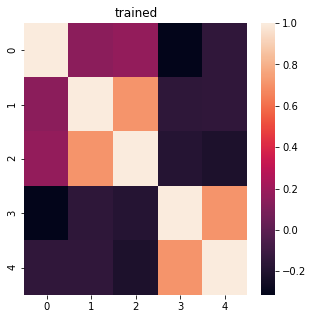

In [119]:
v_tensor = torch.tensor(select_value)

z_n = v_tensor.norm(dim=1)[:,None]
z_n = torch.max(z_n, 1e-8*torch.ones_like(z_n))

cov = torch.mm(v_tensor/z_n, (v_tensor/z_n).t().contiguous())

plt.figure(figsize=(5,5))
plt.title('trained')
sns.heatmap(cov.detach().numpy(), cmap='')

plt.show()

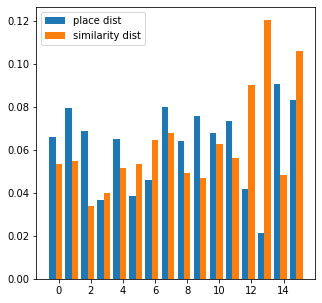

In [123]:
plt.figure(figsize=(5,5))
plt.bar(np.arange(len(KNN_group['294']))-0.4, np.array(list(KNN_group['294'].values()))/sum(list(KNN_group['294'].values())), width=0.4, label='place dist')
plt.bar(np.arange(len(KNN_group['294'])), similarity_list[316]/sum(similarity_list[316]), width=0.4,label='similarity dist')
plt.legend()
plt.show()


In [124]:
KNN_group['294']

{'907': 49.71643416389906,
 '913': 59.843969257304295,
 '917': 51.73032849058811,
 '918': 27.450762844450356,
 '920': 48.993102752191646,
 '926': 28.930231109447085,
 '930': 34.664362808966295,
 '937': 60.09943963326978,
 '938': 48.31400128124823,
 '940': 56.834880949209776,
 '941': 51.16175859415953,
 '944': 55.236275266611486,
 '155': 31.418010634847246,
 '162': 16.153684818933684,
 '288': 68.1294107721191,
 '295': 62.519972248345276}

## Report 4

In [106]:
list(new_windspeed_dataset.keys()).index('318')

4

In [107]:
_result[4]

0.9477371305517828

In [130]:
list(new_windspeed_dataset.keys()).index('100')

263

In [131]:
a_index = 4
b_index = 51
c_index = 57
d_index = 75
e_index = 263

In [132]:
# z list
select_value = []
select_value.append(model_projection[a_index].detach().numpy())
select_value.append(model_projection[b_index].detach().numpy())
select_value.append(model_projection[c_index].detach().numpy())
select_value.append(model_projection[d_index].detach().numpy())
select_value.append(model_projection[e_index].detach().numpy())

# origin
img_a = (img_list[a_index]+1)/2
img_b = (img_list[b_index]+1)/2
img_c = (img_list[c_index]+1)/2
img_d = (img_list[d_index]+1)/2
img_e = (img_list[e_index]+1)/2

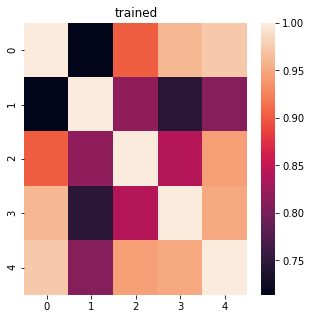

In [134]:
v_tensor = torch.tensor(select_value)

z_n = v_tensor.norm(dim=1)[:,None]
z_n = torch.max(z_n, 1e-8*torch.ones_like(z_n))

cov = torch.mm(v_tensor/z_n, (v_tensor/z_n).t().contiguous())

plt.figure(figsize=(5,5))
plt.title('trained')
sns.heatmap(cov.detach().numpy())

plt.show()

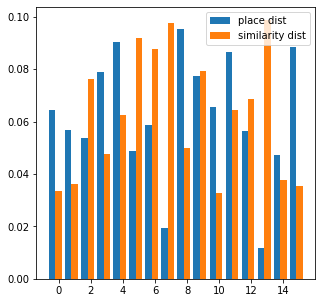

In [135]:
plt.figure(figsize=(5,5))
plt.bar(np.arange(len(KNN_group['318']))-0.4, np.array(list(KNN_group['318'].values()))/sum(list(KNN_group['318'].values())), width=0.4, label='place dist')
plt.bar(np.arange(len(KNN_group['318'])), similarity_list[4]/sum(similarity_list[4]), width=0.4,label='similarity dist')
plt.legend()
plt.show()


In [144]:
np.array(list(KNN_group['318'].keys()))[[-3, 8, 6, 7, 10]]

array(['100', '561', '559', '560', '580'], dtype='<U3')

## Report 5

In [84]:
list(new_windspeed_dataset.keys()).index('162')

282

In [85]:
_result[282]

9.346666471235642

## Report 6

In [86]:
list(new_windspeed_dataset.keys()).index('499')

31

In [87]:
_result[31]

15.707589039676304

---
# Report_3
* 294(인덱스 347)
* 162(309)
* 909(251)
* 918(259)
* 921(262)

[go to content](#Content)

In [28]:
a_index = 347
b_index = 309
c_index = 251
d_index = 259
e_index = 262

In [29]:
# z list
select_value = []
select_value.append(model_projection[a_index].detach().numpy())
select_value.append(model_projection[b_index].detach().numpy())
select_value.append(model_projection[c_index].detach().numpy())
select_value.append(model_projection[d_index].detach().numpy())
select_value.append(model_projection[e_index].detach().numpy())

# origin
img_a = (img_list[a_index]+1)/2
img_b = (img_list[b_index]+1)/2
img_c = (img_list[c_index]+1)/2
img_d = (img_list[d_index]+1)/2
img_e = (img_list[e_index]+1)/2

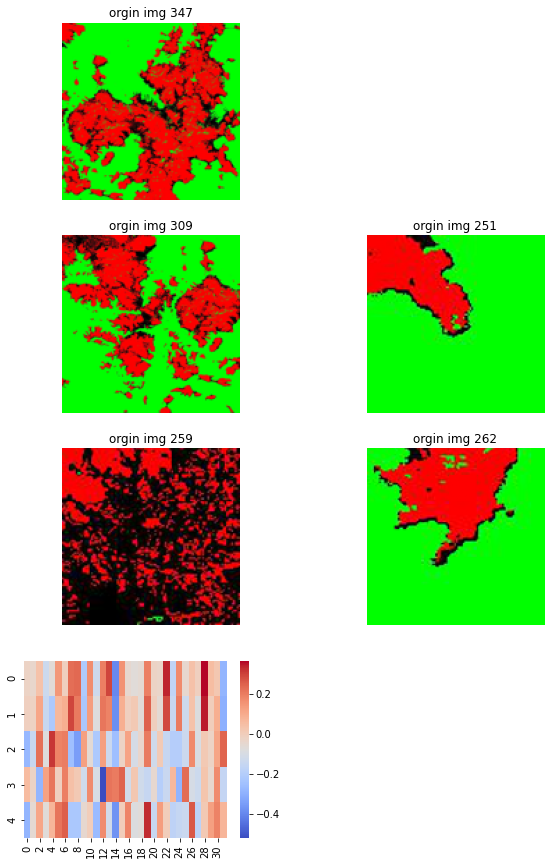

In [30]:
plt.figure(figsize=(10,15))

plt.subplot(4,2,1)
plt.imshow(img_a)
plt.title('orgin img {}'.format(a_index))
plt.axis('off')

plt.subplot(4,2,3)
plt.imshow(img_b)
plt.title('orgin img {}'.format(b_index))
plt.axis('off')

plt.subplot(4,2,4)
plt.imshow(img_c)
plt.title('orgin img {}'.format(c_index))
plt.axis('off')

plt.subplot(4,2,5)
plt.imshow(img_d)
plt.title('orgin img {}'.format(d_index))
plt.axis('off')

plt.subplot(4,2,6)
plt.imshow(img_e)
plt.title('orgin img {}'.format(e_index))
plt.axis('off')

plt.subplot(4,2,7)
sns.heatmap(select_value, cmap='coolwarm')
plt.show()

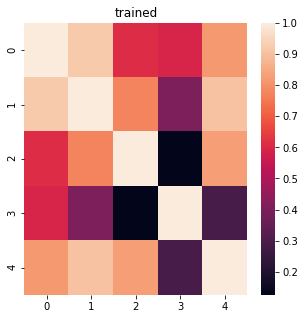

In [17]:
v_tensor = torch.tensor(select_value)

z_n = v_tensor.norm(dim=1)[:,None]
z_n = torch.max(z_n, 1e-8*torch.ones_like(z_n))

cov = torch.mm(v_tensor/z_n, (v_tensor/z_n).t().contiguous())

plt.figure(figsize=(5,5))
plt.title('trained')
sns.heatmap(cov.detach().numpy())

plt.show()

In [19]:
(cov.detach().numpy()[a_index]).argsort()[-2]

309

In [20]:
cov.detach().numpy()[a_index, 309]

0.92294574

In [21]:
list(windspeed_dataset)[309]

'162'

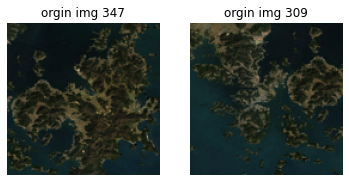

In [23]:
img_similar = (img_list[309]+1)/2

plt.subplot(1,2,1)
plt.imshow(img_a)
plt.title('orgin img {}'.format(a_index))
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(img_similar)
plt.title('orgin img {}'.format('309'))
plt.axis('off')

plt.show()

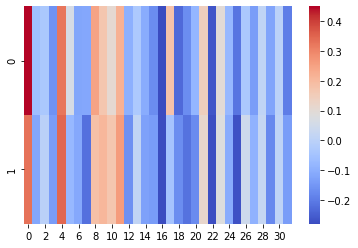

In [25]:
a_z = model_projection[347].detach().numpy().reshape(1,-1)
b_z = model_projection[309].detach().numpy().reshape(1,-1)
total_z = np.concatenate([a_z, b_z], axis=0)

sns.heatmap(total_z, cmap='coolwarm')
plt.show()

* 오... 일단 similar는 VAE에 비해 상다잏 좋은데?

### Report_1
* 66번 인덱스와 39번 인덱스 차이 비교

[go to content](#Content)

In [23]:
select_value = []
select_value.append(model_projection[66].detach().numpy())
select_value.append(model_projection[39].detach().numpy())

<AxesSubplot:>

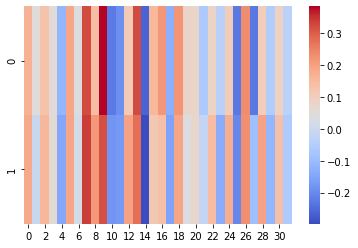

In [26]:
sns.heatmap(select_value, cmap='coolwarm')